## Unconditioned Symbolic Generation

### Motivation

During my exploration of the possible symbolic music generation datasets I could use, I noticed one prevailing trend: **MIDI files are hard to find**.

It seems that in the modern day, MIDI is not a commonly used format. Datasets of modern music transribed to MIDI don't exist (maybe for copyright reasons). The diversity of existing MIDI datasets is very poor - a large portion of datasets only focus on piano music.

This gave rise to an idea: I should try to generate some modern style distinct from the existing piano-dominated MIDI music by doing fine-tuning on an existing model.

I decided to focus on a very popular music genre on Youtube that I personally use: **lofi study beats**.

### Related Works

https://ai.plainenglish.io/building-a-lo-fi-hip-hop-generator-e24a005d0144

This work also tackles the task of lofi hip hop music generation, and they manually curate a dataset of around ~100 MIDI files, which I will be using.

Pretrained on a small corpus of piano music, then trains an LSTM model on a sequence of note pitches extracted using `music21`, but this throws away all other information.

Pop Music Transformer (Huang & Yang, 2020)

REMI tokenization - Note duration tokens, Bar + position, tempo chord

https://github.com/patchbanks/Pop-K?tab=readme-ov-file

RWKV - An RNN that is efficient to train and supposedly as performant (if not better) than a Transformer (only observed at small scale).

No paper on this MIDI generator model, but I chose it for 2 reasons: already trained on "modern" pop music, so might sound distinct from model trained on piano midis. More compute efficient to train than a large transformer.

### Data Analysis

In [ ]:
%pip install music21

In [ ]:
import music21
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict

In [ ]:
def basic_data_analysis(path_list: list[str], dataset_name: str) -> None:
    score_list = [music21.converter.parse(mid) for mid in tqdm(path_list, desc="Parsing MIDIs")]
    
    # Dataset Length
    print(f"Length of {dataset_name} Dataset: {len(path_list)}")

    # Key Signature Distribution
    key_counts = defaultdict(int)
    for score in score_list:
        key = score.analyze('key')
        key_counts[str(key)] += 1
    key_counts = dict(sorted(key_counts.items()))

    # Time Signature Distribution
    time_sig_counts = defaultdict(int)
    for score in score_list:
        for ts in score.getTimeSignatures():
            time_sig_counts[f"{ts.beatCount}/{ts.denominator}"] += 1
    time_sig_counts = dict(sorted(time_sig_counts.items()))

    # Num Tracks Distribution
    num_track_counts = defaultdict(int)
    for score in score_list:
        num_tracks = len(score.parts)
        num_track_counts[str(num_tracks)] += 1
    num_track_counts = dict(sorted(num_track_counts.items()))

    # Tempo Distribution
    tempo_counts = defaultdict(int)
    for score in score_list:
        for tempo in score.recurse().getElementsByClass(music21.tempo.MetronomeMark):
            tempo_counts[float(tempo.number) if tempo is not None else "None"] += 1
    tempo_counts = dict(sorted(tempo_counts.items()))

    # Pitch Class Distribution
    pitch_class_counts = defaultdict(int)
    for score in score_list:
        notes = score.flatten().notes
        for n in notes:
            if isinstance(n, music21.note.Note):
                pitch_class_counts[str(n.pitch.name)] += 1
    pitch_class_counts = dict(sorted(pitch_class_counts.items()))

    # Duration Distribution
    duration_counts = defaultdict(int)
    for score in score_list:
        duration = score.duration.quarterLength
        duration_counts[int(duration)] += 1
    duration_counts = dict(sorted(duration_counts.items()))

    fig, axs = plt.subplots(2, 3, figsize=(18, 8))
    axs[0][0].bar(key_counts.keys(), key_counts.values())
    axs[0][0].set_xlabel('Key Signature')
    axs[0][0].set_ylabel('Count')
    axs[0][0].set_xticks(list(key_counts.keys()))
    axs[0][0].tick_params(axis='x', rotation=45)
    axs[0][0].set_title('Key Signature Distribution')

    axs[0][1].bar(time_sig_counts.keys(), time_sig_counts.values())
    axs[0][1].set_xlabel('Time Signature')
    axs[0][1].set_ylabel('Count')
    axs[0][1].set_xticks(list(time_sig_counts.keys()))
    axs[0][1].set_title('Time Signature Distribution')

    axs[0][2].bar(num_track_counts.keys(), num_track_counts.values())
    axs[0][2].set_xlabel('Number of Tracks')
    axs[0][2].set_ylabel('Count')
    axs[0][2].set_xticks(list(num_track_counts.keys()))
    axs[0][2].set_title('Number of Tracks Distribution')

    axs[1][0].hist(list(tempo_counts.keys()), weights=list(tempo_counts.values()), bins=20)
    axs[1][0].set_xlabel('Tempo (BPM)')
    axs[1][0].set_ylabel('Count')
    axs[1][0].set_title('Tempo Distribution')

    axs[1][1].bar(pitch_class_counts.keys(), pitch_class_counts.values())
    axs[1][1].set_xlabel('Pitch Class')
    axs[1][1].set_ylabel('Count')
    axs[1][1].set_xticks(list(pitch_class_counts.keys()))
    axs[1][1].set_title('Pitch Class Distribution')

    axs[1][2].hist(list(duration_counts.keys()), weights=list(duration_counts.values()), bins=20)
    axs[1][2].set_xlabel('Duration (in quarter notes)')
    axs[1][2].set_ylabel('Count')
    axs[1][2].set_title('Duration Distribution')

    plt.tight_layout()
    plt.show()

#### Pop-K Dataset (1000 random subset)

Parsing MIDIs: 100%|██████████| 300/300 [01:04<00:00,  4.65it/s]


Length of Pop Music Transformer Dataset: 300


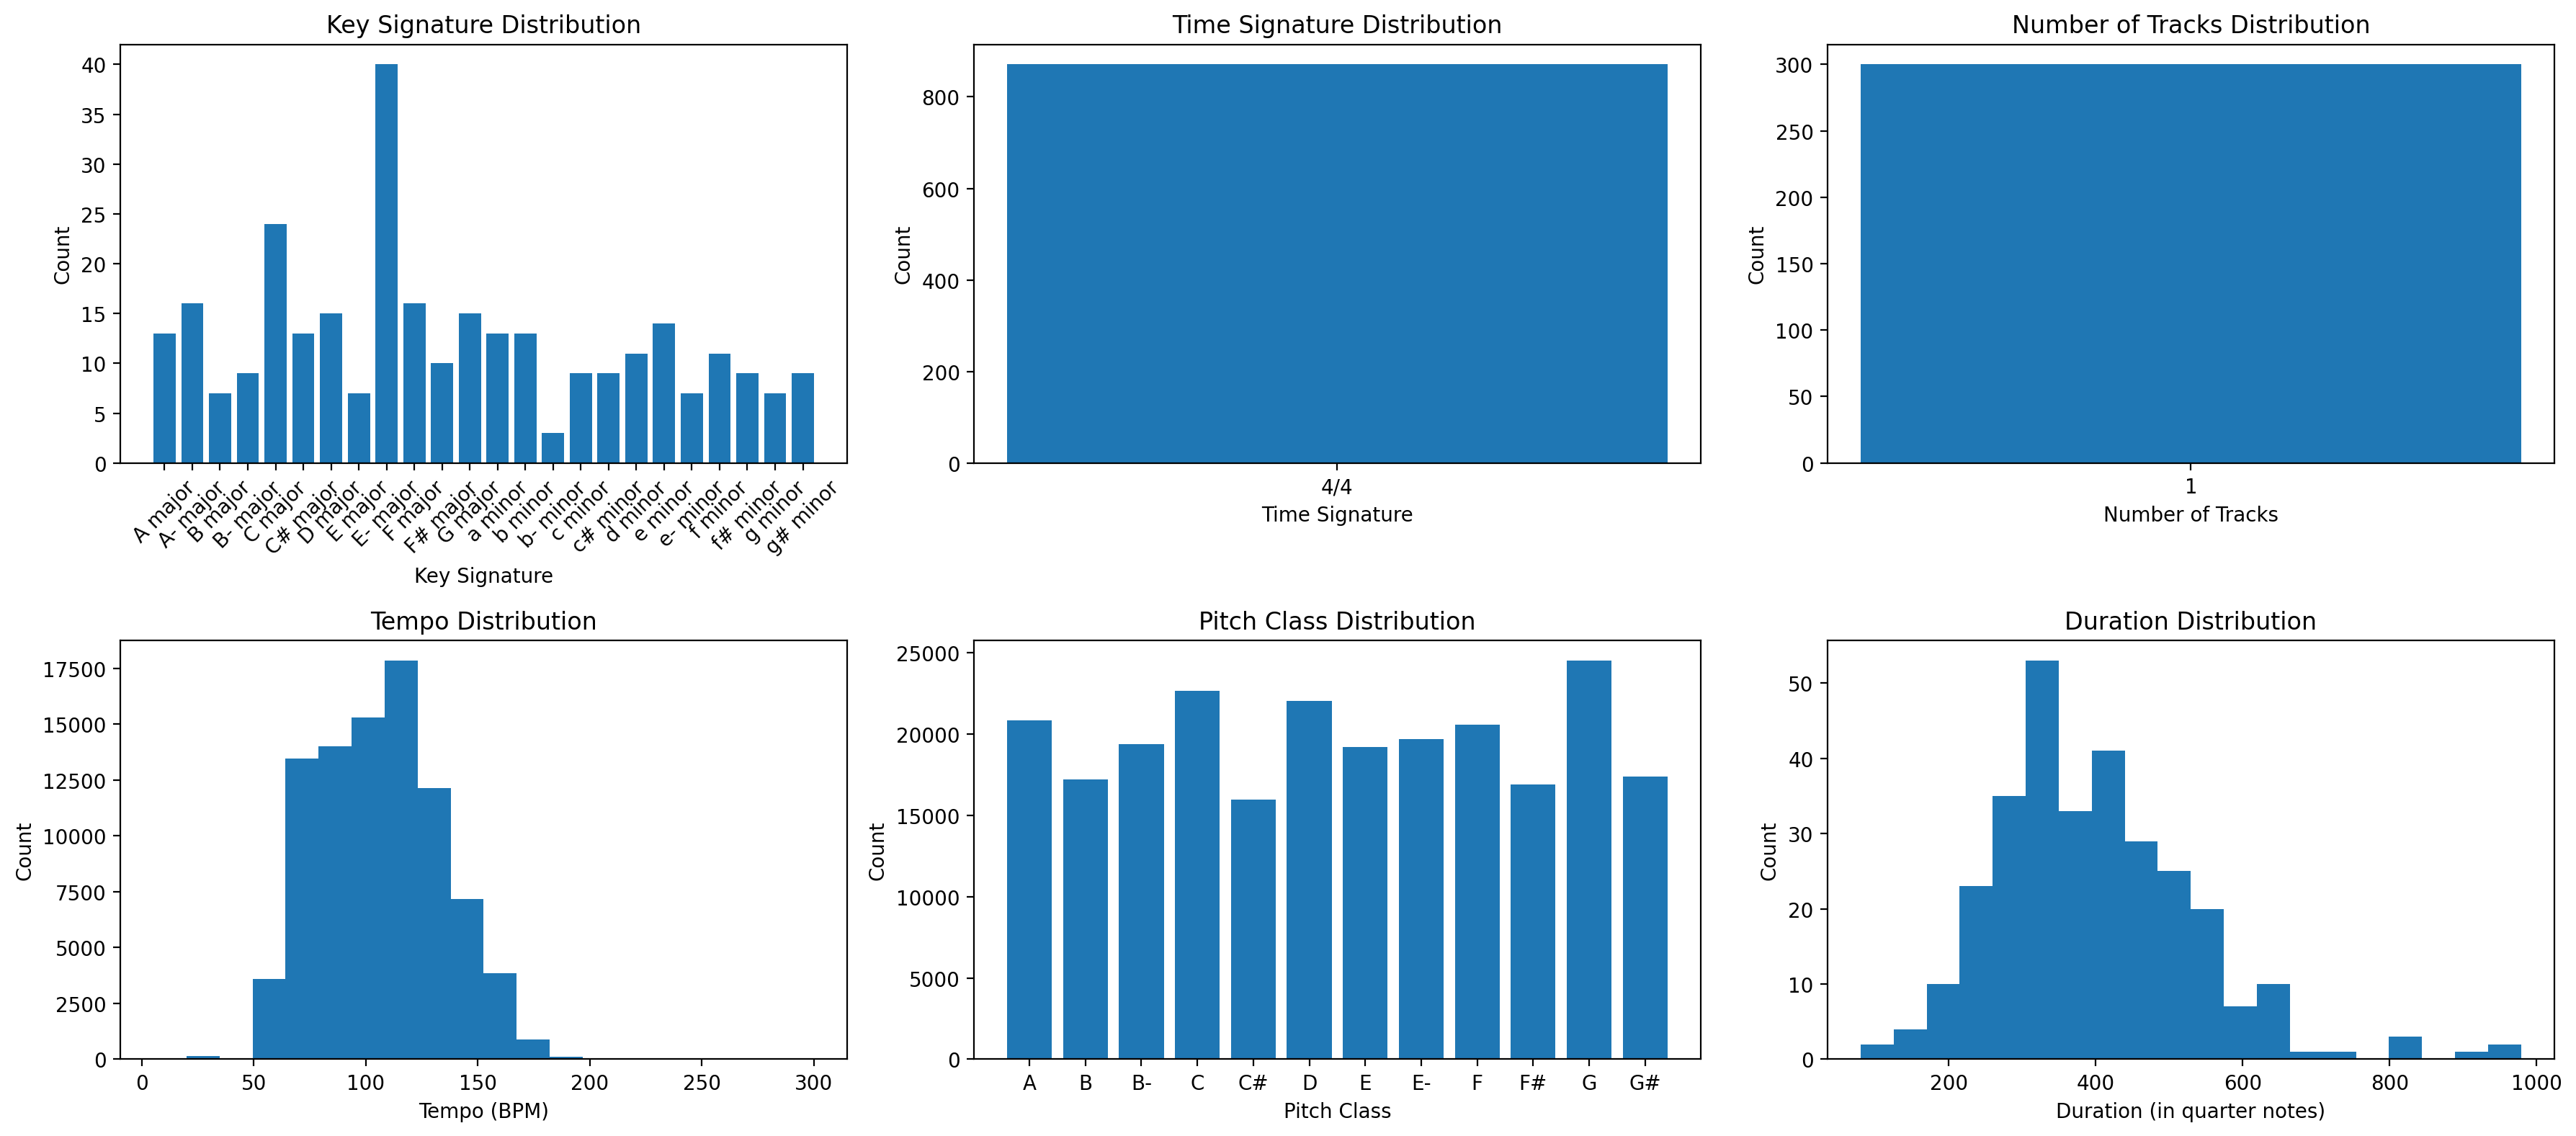

In [ ]:
POP_MUSIC_TRANSFORMER = glob("data/pop-music-transformer/train/*.midi")
basic_data_analysis(POP_MUSIC_TRANSFORMER[:300], "Pop Music Transformer") # Only process 300 midi files because whole dataset takes too long.

#### LOFI ~100 Dataset

Parsing MIDIs: 100%|██████████| 103/103 [00:00<00:00, 307.31it/s]


Length of LOFI ~100 Dataset: 103


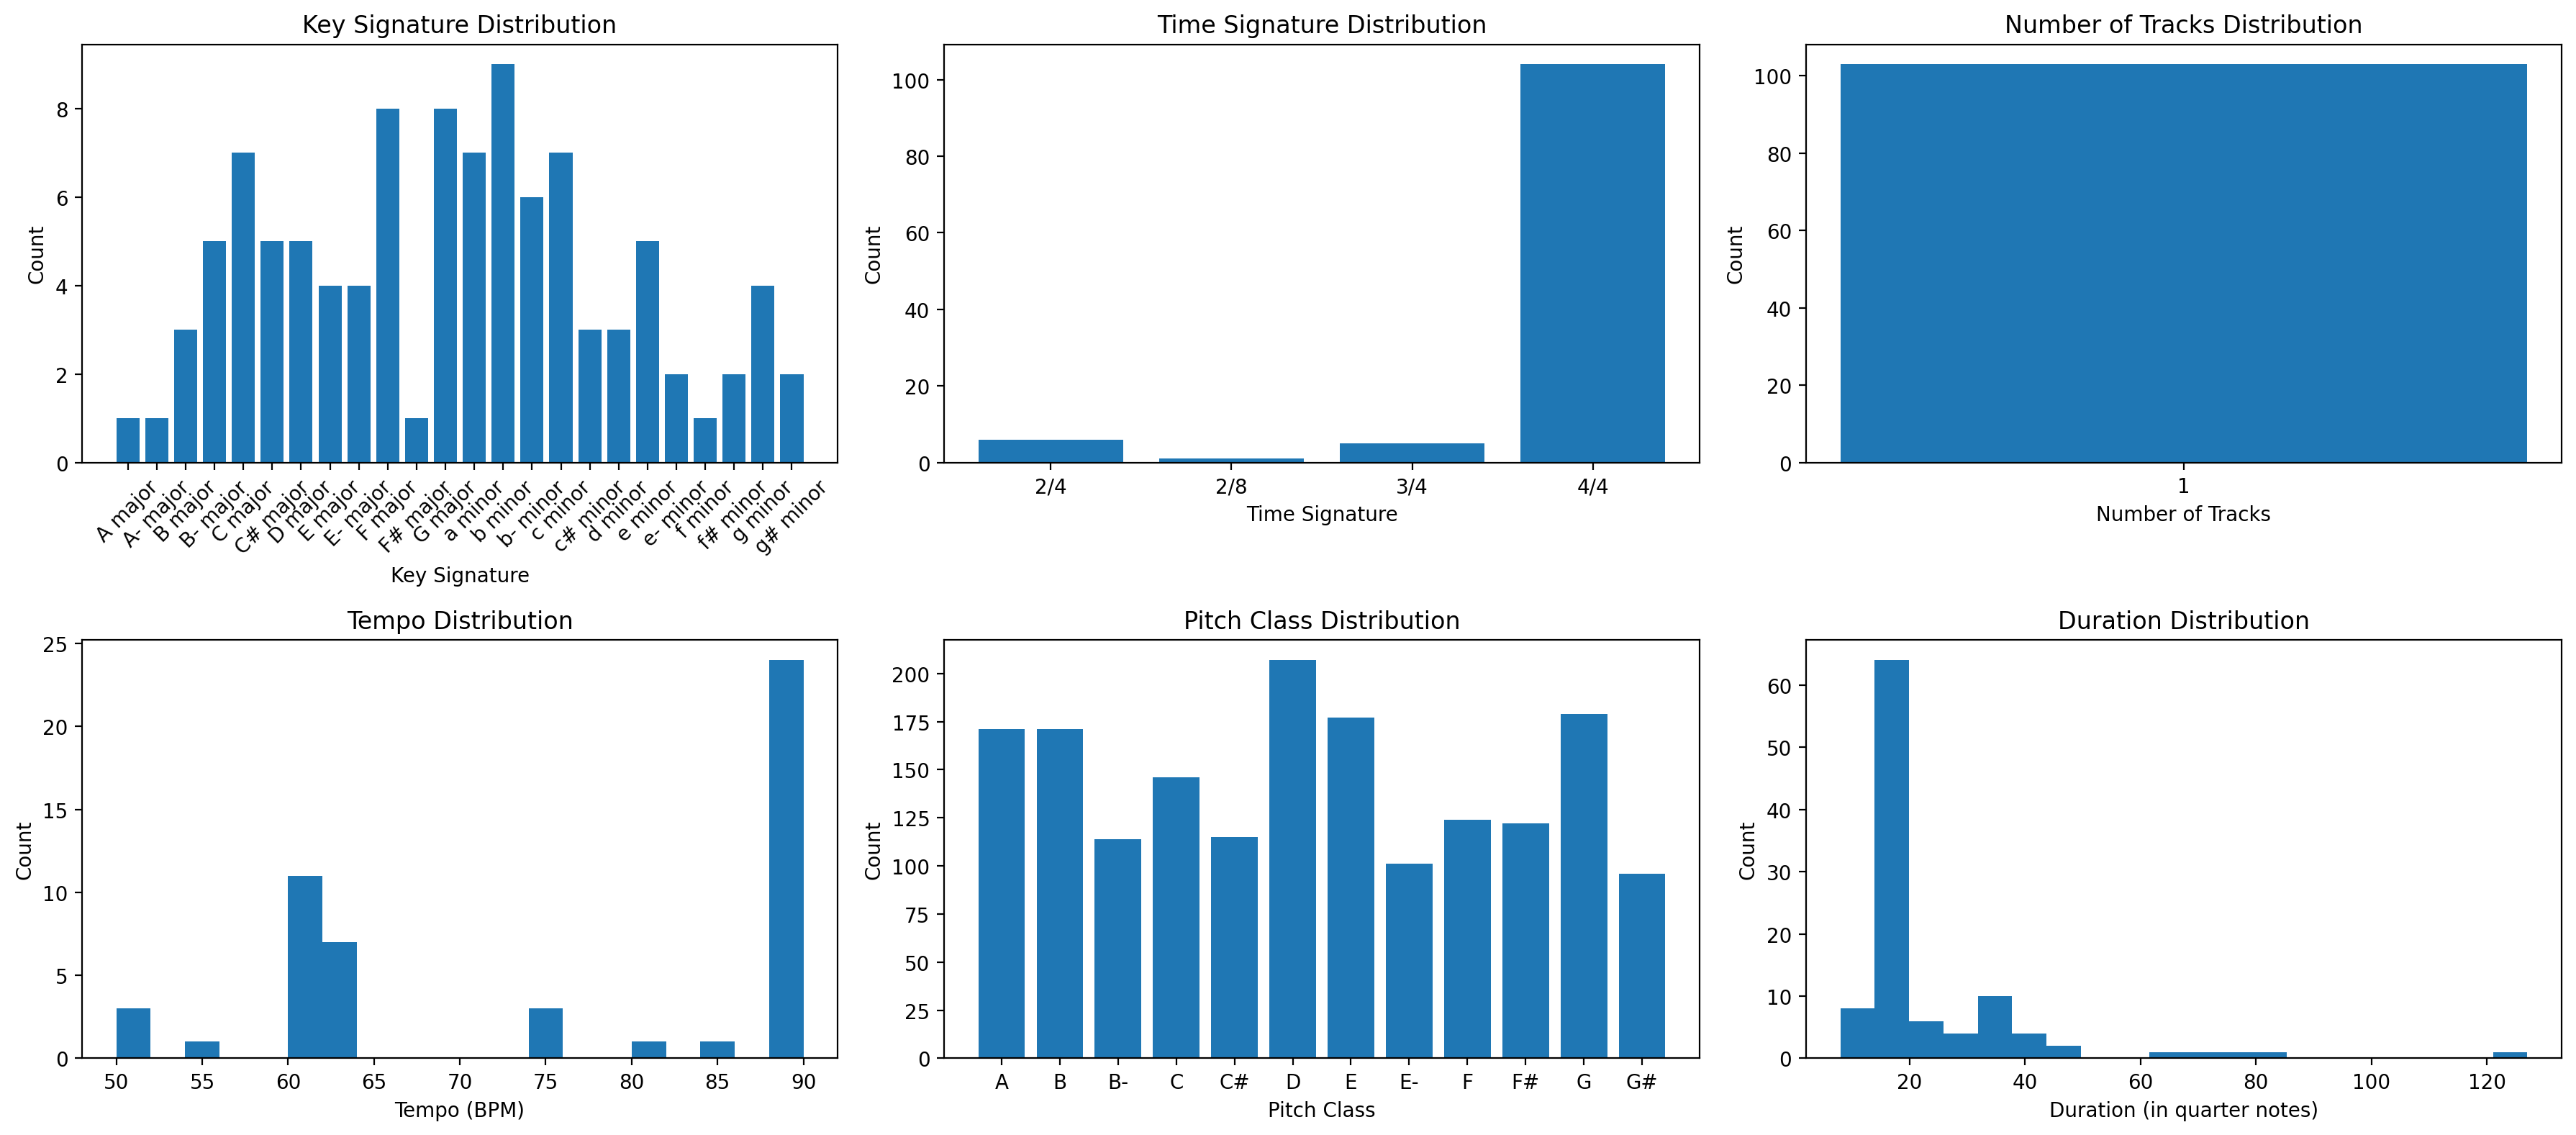

In [75]:
LOFI_100 = glob("data/lofi/*.mid")
basic_data_analysis(LOFI_100, "LOFI ~100")

#### LOFI Peaceful Piano Dataset

Parsing MIDIs: 100%|██████████| 261/261 [00:38<00:00,  6.86it/s]


Length of LOFI Peaceful Piano Dataset: 261


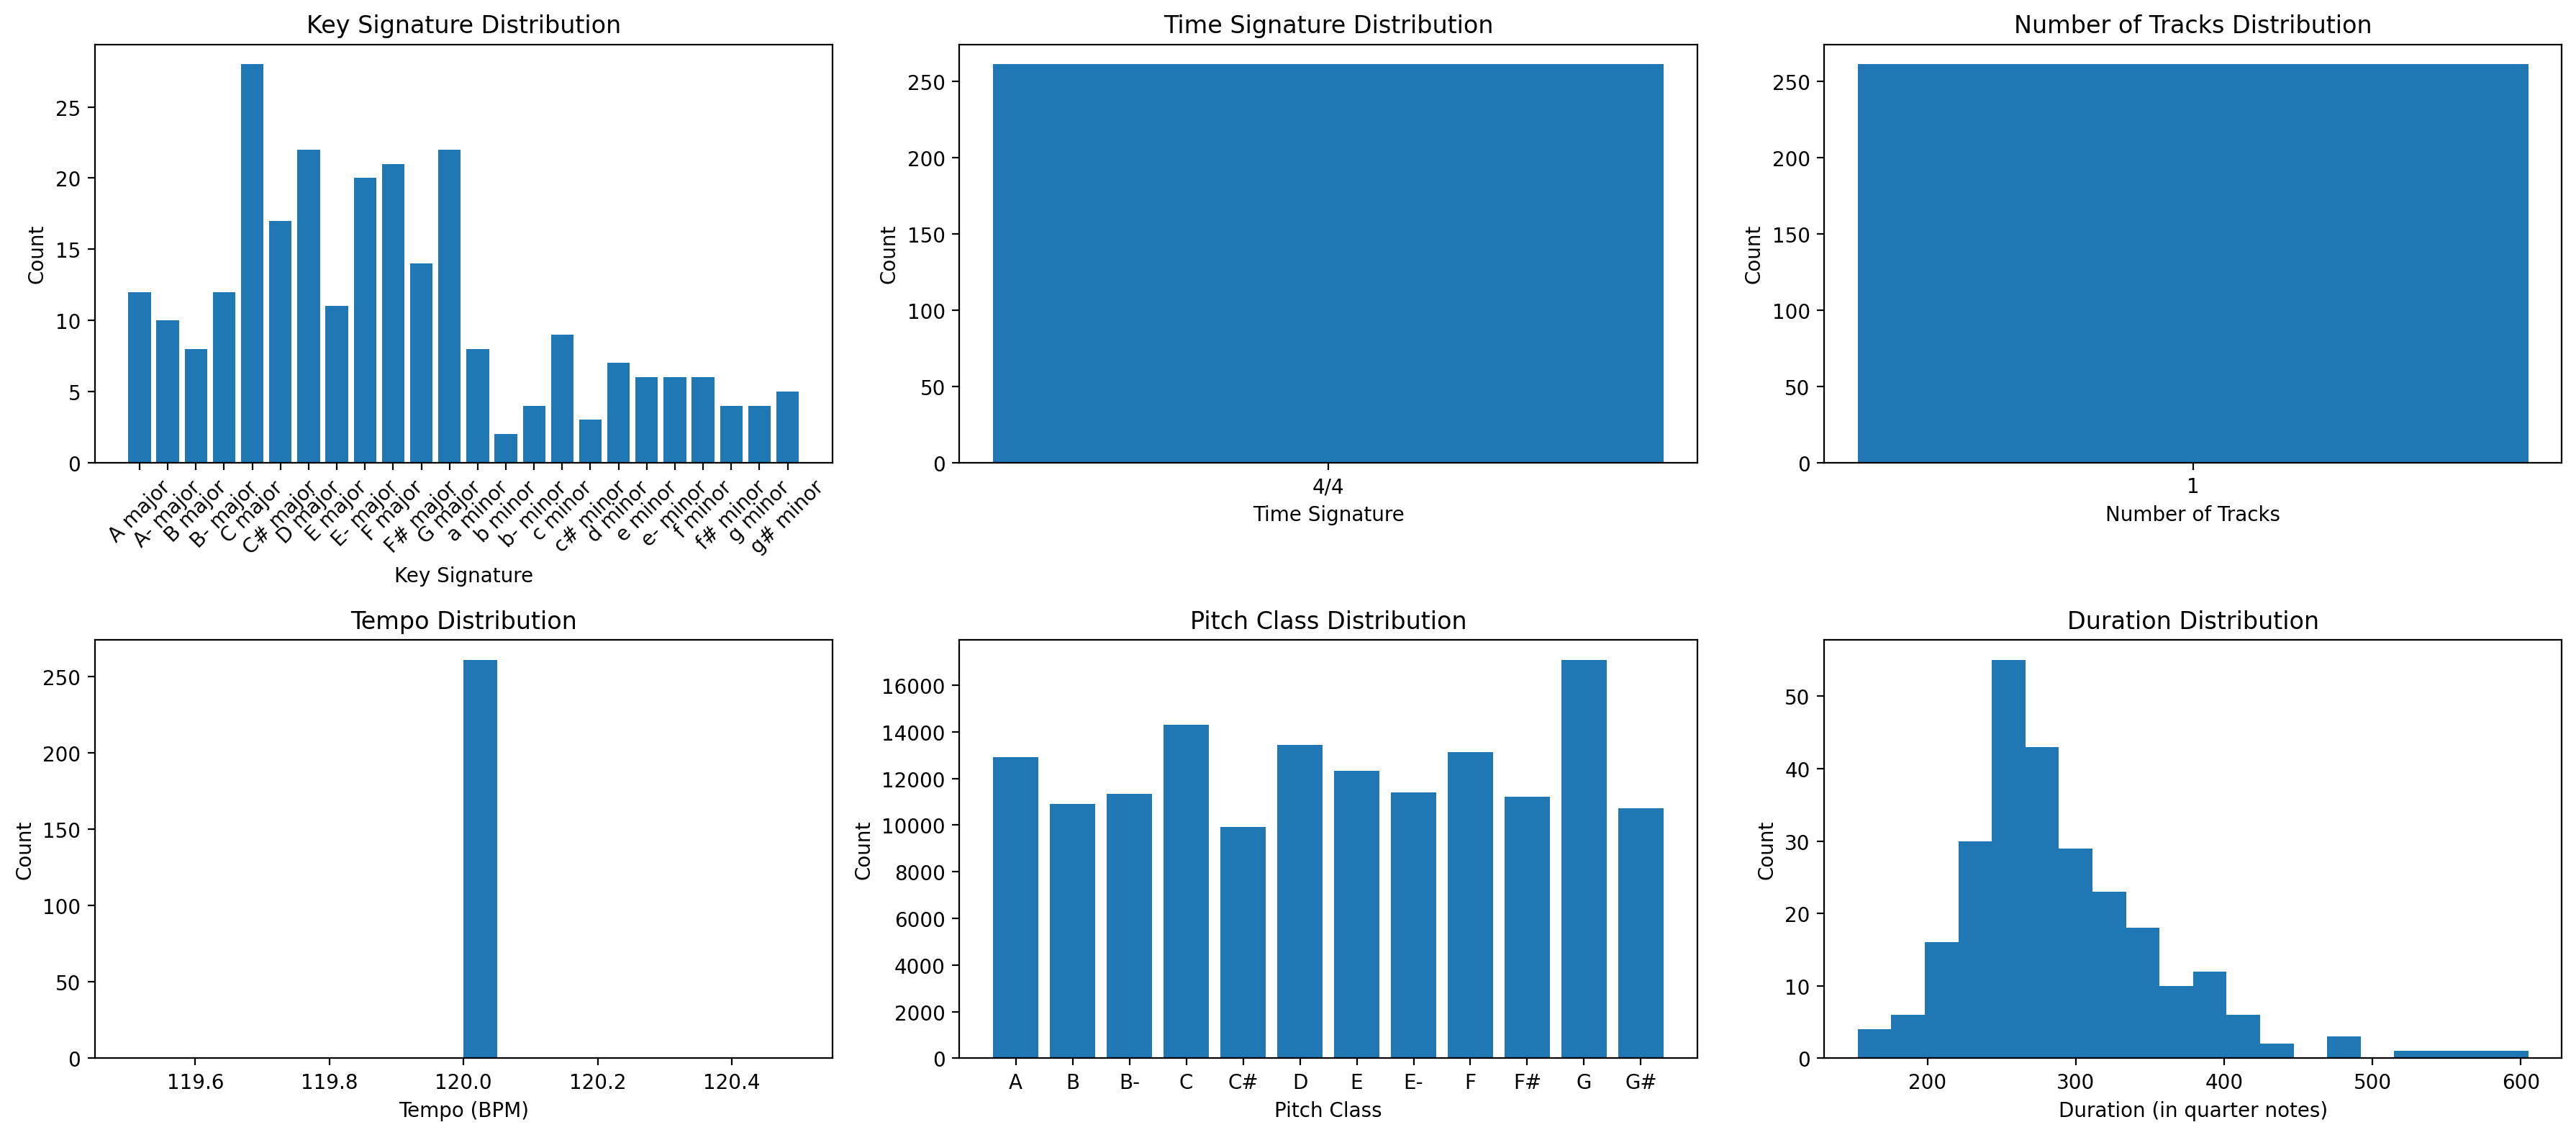

In [76]:
LOFI_PEACEFUL_PIANO = glob("data/soundcloud/peaceful-piano-midi/*.mid")
basic_data_analysis(LOFI_PEACEFUL_PIANO, "LOFI Peaceful Piano")

In [ ]:
import os
from model import PopMusicTransformer

In [ ]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

model = PopMusicTransformer(
    checkpoint='REMI-tempo-checkpoint',
    is_training=True)

training_data = model.prepare_data(midi_paths=LOFI_100 + LOFI_PEACEFUL_PIANO)

output_checkpoint_folder = 'REMI-lofi-finetune'
if not os.path.exists(output_checkpoint_folder):
    os.mkdir(output_checkpoint_folder)

model.finetune(
    training_data=training_data,
    output_checkpoint_folder=output_checkpoint_folder)

####################################
# after finetuning, please choose which checkpoint you want to try
# and change the checkpoint names you choose into "model"
# and copy the "dictionary.pkl" into the your output_checkpoint_folder
# ***** the same as the content format in "REMI-tempo-checkpoint" *****
# and then, you can use "main.py" to generate your own music!
# (do not forget to revise the checkpoint path to your own in "main.py")
####################################

model.close()

In [ ]:
from model import PopMusicTransformer
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

model = PopMusicTransformer(
    checkpoint='REMI-tempo-checkpoint',
    is_training=False)

# generate from scratch
model.generate(
    n_target_bar=16,
    temperature=1.2,
    topk=5,
    output_path='./result/from_scratch.midi',
    prompt=None)

# close model
model.close()